## KMeans Notebook

By: Megan Grout (groutm@ohsu.edu)

Adapted from code written by Dr. Marilyne Labrie and Nick Kendsersky


Last updated: 20191213

In [2]:
import os
import random
import re
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import subprocess


from scipy import signal

import plotly.figure_factory as ff
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
init_notebook_mode(connected = True)

In [3]:
from cycif_modules import *

## Functions

In [4]:
# This may change for each experiment, so I have not sequestered
# this code in the my_modules.py file

# This function takes in a dataframe, changes the names
# of the column in various ways, and returns the dataframe.
# For best accuracy and generalizability, the code uses
# regular expressions (regex) to find strings for replacement.
def apply_header_changes(df):
    # remove lowercase x at beginning of name
    df.columns = df.columns.str.replace("^x","")
    # remove space at beginning of name
    df.columns = df.columns.str.replace("^ ","")
    # replace space with underscore
    df.columns = df.columns.str.replace(" ","_")
    # fix typos
    df.columns = df.columns.str.replace("CKD1","CDK1")
    df.columns = df.columns.str.replace("GAG3","GATA3")
    return df

## Begin Workflow

### Get directories

In [5]:
#set directory
## needs to be user iput

# Base directory for project
base_dir = '/Users/groutm/Desktop/weewin'
base_dir = '/Users/groutm/Desktop/reproducibility'
base_dir = 'Z:\Marilyne\Axioscan\Gao_Zhang\Segmentation'
base_dir = '/Users/groutm/Desktop/gz_new'



project_name = 'ww'
project_name = 'repro'
project_name = 'gz_new'

step_suffix = 'kmeans'
previous_step_suffix_long = "_zscore"

# Initial input data directory
#input_data_dir = r'/Users/groutm/Desktop/TMAdata'
#input_data_dir = r'/Users/groutm/Desktop/ww_data'
input_data_dir = os.path.join(base_dir, project_name + previous_step_suffix_long)


# log2/z-score directory
#output_data_dir = r'/Users/groutm/Desktop/TMAoutputdata'
#output_data_dir = r'/Users/groutm/Desktop/ww_outputdata'
output_data_dir = os.path.join(base_dir, project_name + "_" + step_suffix)

# log2/z-score images subdirectory
#output_images_dir = r'/Users/groutm/Desktop/TMAimages'
#output_images_dir = r'/Users/groutm/Desktop/wwimages'
output_images_dir = os.path.join(output_data_dir,"images")

# Metadata directories
metadata_dir = os.path.join(base_dir, project_name + "_metadata")
metadata_images_dir = os.path.join(metadata_dir,"images")

for d in [base_dir, input_data_dir, output_data_dir, output_images_dir, 
          metadata_dir, metadata_images_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

os.chdir(input_data_dir)



In [30]:
## Comment for final workflow

ls_samples = ['TMA','ww1', 'ww10', 'ww11', 'ww12', 'ww13', 'ww15', 
              'ww16', 'ww17', 'ww19', 'ww2', 'ww20', 'ww21', 
              'ww22', 'ww23', 'ww3', 'ww4', 'ww5', 'ww6', 'ww7', 
              'ww8', 'ww9']#,'bad_header_file']

ls_samples = ['TMA1.1', 'TMA1.2', 'TMA1.3', 'TMA2.1', 'TMA2.2', 'TMA2.3']

ls_samples = ['GZ10.1', 'GZ10.2', 'GZ10.3', 'GZ7.1', 'GZ6', 'GZ7.2']

ls_samples = ['A_GZ2', 'B_GZ1', 'C_GZ5', 'D_GZ4', 'E_GZ3','F_GZ6','G_GZ7', 
              'H_GZ9',
              'I_GZ10']

## Import all metadata we need from the QC/EDA chapter

### metadata

In [7]:
filename = "marker_intensity_metadata.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [8]:
# Open, read in information
metadata = pd.read_csv(filename)

# Verify size
##verify_line_no(filename, metadata.shape[0] + 1)


# Verify headers
exp_cols = ['Round','Target','Channel','target_lower','full_column','marker','location']
compare_headers(exp_cols, metadata.columns.values, "Marker metadata file")

['Exp']


In [9]:
# Show some of dataframe - FYI
metadata.head()

,Round,Target,Exp,Channel,target_lower,full_column,marker,location
0,R0,AF488,300,c2,af488,AF488_Cell_Intensity_Average,AF488,cell
1,R0,AF555,1500,c3,af555,AF555_Cell_Intensity_Average,AF555,cell
2,R0,AF647,1500,c4,af647,AF647_Cell_Intensity_Average,AF647,cell
3,R0,AF750,1500,c5,af750,AF750_Cell_Intensity_Average,AF750,cell
4,R1,H3K27me3,200,c2,h3k27me3,H3K27me3_Cell_Intensity_Average,H3K27me3,cell


### not_intensities

In [10]:
filename = "not_intensities.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [11]:
# Open, read in information
not_intensities = []
with open(filename, 'r') as fh:
    not_intensities = fh.read().strip().split("\n")
    # take str, strip whitespace, split on new line character

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, len(not_intensities))

# Print to console
print("not_intensities = ")
print(not_intensities)

Verifying data read from file is the correct length...

not_intensities = 
['Nuc_X', 'Nuc_X_Inv', 'Nuc_Y', 'Nuc_Y_Inv', 'Nucleus_Roundness', 'Nucleus_Size', 'Cell_Size', 'ROI_index', 'Sample_ID', 'replicate_ID', 'Cell_ID', 'cell_type', 'cluster', 'ID']


### full_to_short_column names

In [12]:
filename = "full_to_short_column_names.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [13]:
# Open, read in information
df = pd.read_csv(filename, header = 0)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
full_to_short_names = df.set_index('full_name').T.to_dict('records')[0]

# Print information
print('full_to_short_names =')
print(full_to_short_names)

Verifying data read from file is the correct length...

full_to_short_names =
{'53BP1_Cell_Intensity_Average': '53BP1', 'AF488_Cell_Intensity_Average': 'AF488', 'AF555_Cell_Intensity_Average': 'AF555', 'AF647_Cell_Intensity_Average': 'AF647', 'AF750_Cell_Intensity_Average': 'AF750', 'AXL_Cell_Intensity_Average': 'AXL', 'CCNA2_Cell_Intensity_Average': 'CCNA2', 'CCND1_Cell_Intensity_Average': 'CCND1', 'CD45_Cell_Intensity_Average': 'CD45', 'CD4_Cell_Intensity_Average': 'CD4', 'CD68_Cell_Intensity_Average': 'CD68', 'CD8_Cell_Intensity_Average': 'CD8', 'EGFR_Cell_Intensity_Average': 'EGFR', 'Ecad_Cell_Intensity_Average': 'Ecad', 'FOXP3_Cell_Intensity_Average': 'FOXP3', 'H3K27me3_Cell_Intensity_Average': 'H3K27me3', 'KI67_Cell_Intensity_Average': 'KI67', 'MITF_Cell_Intensity_Average': 'MITF', 'PCNA_Cell_Intensity_Average': 'PCNA', 'PDGFR_Cell_Intensity_Average': 'PDGFR', 'S100_Cell_Intensity_Average': 'S100', 'Vimentin_Cell_Intensity_Average': 'Vimentin', 'p4EBP1_Cell_Intensity_Average': 'p

### short_to_full_column_names

In [14]:
filename = "short_to_full_column_names.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [15]:
# Open, read in information
df = pd.read_csv(filename, header = 0)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
short_to_full_names = df.set_index('short_name').T.to_dict('records')[0]

# Print information
print('short_to_full_names =')
print(short_to_full_names)

Verifying data read from file is the correct length...

short_to_full_names =
{'53BP1': '53BP1_Cell_Intensity_Average', 'AF488': 'AF488_Cell_Intensity_Average', 'AF555': 'AF555_Cell_Intensity_Average', 'AF647': 'AF647_Cell_Intensity_Average', 'AF750': 'AF750_Cell_Intensity_Average', 'AXL': 'AXL_Cell_Intensity_Average', 'CCNA2': 'CCNA2_Cell_Intensity_Average', 'CCND1': 'CCND1_Cell_Intensity_Average', 'CD45': 'CD45_Cell_Intensity_Average', 'CD4': 'CD4_Cell_Intensity_Average', 'CD68': 'CD68_Cell_Intensity_Average', 'CD8': 'CD8_Cell_Intensity_Average', 'EGFR': 'EGFR_Cell_Intensity_Average', 'Ecad': 'Ecad_Cell_Intensity_Average', 'FOXP3': 'FOXP3_Cell_Intensity_Average', 'H3K27me3': 'H3K27me3_Cell_Intensity_Average', 'KI67': 'KI67_Cell_Intensity_Average', 'MITF': 'MITF_Cell_Intensity_Average', 'PCNA': 'PCNA_Cell_Intensity_Average', 'PDGFR': 'PDGFR_Cell_Intensity_Average', 'S100': 'S100_Cell_Intensity_Average', 'Vimentin': 'Vimentin_Cell_Intensity_Average', 'p4EBP1': 'p4EBP1_Cell_Intensity_Av

### Color information

#### Samples

In [16]:
filename = "sample_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: " + filename)

In [17]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
sample_color_dict = df.set_index('Sample_ID').T.to_dict('rgb')[0]

# Print information
print('sample_color_dict =')
print(sample_color_dict)


Verifying data read from file is the correct length...

sample_color_dict =
{'A_GZ2': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'B_GZ1': (0.8616090647292522, 0.536495730113334, 0.19548899031476086), 'C_GZ5': (0.6804189127793346, 0.6151497514677574, 0.19405452111445337), 'D_GZ4': (0.46810256823426105, 0.6699492535792404, 0.1928958739904499), 'E_GZ3': (0.20125317221201128, 0.6907920815379025, 0.47966761189275336), 'F_GZ6': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), 'G_GZ7': (0.2197995660828324, 0.6625157876850336, 0.7732093159317209), 'H_GZ9': (0.433280341176423, 0.6065273407962815, 0.9585467098271748), 'I_GZ10': (0.8004936186423958, 0.47703363533737203, 0.9579547196007522), 'TMA': (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)}


#### Channels

In [18]:
filename = "channel_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [19]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
channel_color_dict = df.set_index('Channel').T.to_dict('rgb')[0]

# Print information
print('channel_color_dict =')
print(channel_color_dict)


Verifying data read from file is the correct length...

channel_color_dict =
{'c3': (1.0, 0.6470588235294118, 0.0), 'c4': (1.0, 0.0, 0.0), 'c5': (0.25098039215686274, 0.8784313725490196, 0.8156862745098039), 'c2': (0.0, 0.5019607843137255, 0.0)}


#### Round

In [20]:
filename = "round_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [21]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
round_color_dict = df.set_index('Round').T.to_dict('rgb')[0]

# Print information
print('round_color_dict =')
print(round_color_dict)

Verifying data read from file is the correct length...

round_color_dict =
{'R0': (0.28685356234627135, 0.13009829239513535, 0.23110332132624437), 'R1': (0.3736023974468758, 0.214424058315835, 0.3978381676792029), 'R2': (0.4159341362257507, 0.3236230119238674, 0.5522993139842536), 'R3': (0.4347275623260717, 0.45841778084048856, 0.6693193307565182), 'R4': (0.45985383722977585, 0.5938507827180669, 0.7299938636762819), 'R5': (0.5193510814616777, 0.7186903518953451, 0.7537488291211205), 'R6': (0.6251959781814483, 0.8211474484187268, 0.77115296242133), 'R7': (0.7684256891219349, 0.8992667116749021, 0.8171383269422353)}


#### Cell Type

In [22]:
filename = "celltype_color_data.csv"
filename = os.path.join(metadata_dir, filename)

# Check file exists
if not os.path.exists(filename):
    print("WARNING: Could not find desired file: "+filename)

In [23]:
# Open, read in information
df = pd.read_csv(filename, header = 0)
df = df.drop(columns = ['hex'])

# our tuple of float values for rgb, (r, g, b) was read in 
# as a string '(r, g, b)'. We need to extract the r-, g-, and b-
# substrings and convert them back into floats
df['rgb'] = df.apply(lambda row: rgb_tuple_from_str(row['rgb']), axis = 1)

# Verify size
print("Verifying data read from file is the correct length...\n")
#verify_line_no(filename, df.shape[0] + 1)

# Turn into dictionary
celltype_color_dict = df.set_index('cell_type').T.to_dict('rgb')[0]

# Print information
print('celltype_color_dict =')
print(celltype_color_dict)

Verifying data read from file is the correct length...

celltype_color_dict =
{'STROMA': (0.86, 0.3712, 0.33999999999999997), 'CANCER': (0.33999999999999997, 0.86, 0.3712), 'IMMUNE': (0.3712, 0.33999999999999997, 0.86)}


## Import data

Prompt user for any files they would like excluded from analysis.

In [24]:
# Import all data files for this portion of workflow

# First gather information on expected headers using first file in ls_samples

# Read in the first row of the file correpsonding to the first sample (index = 0)
# in ls_samples
df = pd.read_csv(ls_samples[0] + 
                 previous_step_suffix_long + ".csv", nrows = 1, index_col = 0)

# Apply the changes to the headers as specified in above funciton
df = apply_header_changes(df)

# Set variable to hold default header values
expected_headers = df.columns.values

print("df index name is currently",df.index.name)

df index name is currently None


In [25]:
df.head()

,53BP1,AXL,CCNA2,CCND1,CD45,CD4,CD68,CD8,Cell_Size,EGFR,...,p4EBP1,p75,pATM,pATR,pCHK2,pEGFR,pGSK3b,pH2AX,pHH3,pS6
A_GZ2_Cell_0,-0.682094,-1.638605,-2.213975,-1.388343,-1.810311,-1.011022,-1.683999,-0.025108,329,-2.157665,...,-1.929355,0.398482,-2.128896,-0.035847,-1.2362,-1.695086,-1.76626,-1.656667,1.721911,0.708195


In [26]:
print("Used " + ls_samples[0] + previous_step_suffix_long +
      ".csv to determine the expected, corrected headers for all files.")
print("There headers are: \n" + ", ".join([h for h in expected_headers]) + ".")

Used A_GZ2_zscore.csv to determine the expected, corrected headers for all files.
There headers are: 
53BP1, AXL, CCNA2, CCND1, CD45, CD4, CD68, CD8, Cell_Size, EGFR, Ecad, FOXP3, H3K27me3, KI67, MITF, Nuc_X, Nuc_X_Inv, Nuc_Y, Nuc_Y_Inv, Nucleus_Roundness, Nucleus_Size, PCNA, PDGFR, ROI_index, S100, Sample_ID, Vimentin, cell_type, p4EBP1, p75, pATM, pATR, pCHK2, pEGFR, pGSK3b, pH2AX, pHH3, pS6.


In [38]:
# Import all dfs

## TO-DO: include check that imported df is the expected size and shape...

dfs = {}
for sample in ls_samples:
    print(sample)
    # Open file
    ################################
    # only reading first 500 lines #
    ################################
    
    if not os.path.exists(sample+previous_step_suffix_long+".csv"):
        print("File " + sample+previous_step_suffix_long+".csv" +
             " does not exist. Removing from analysis...")
        ls_samples.remove(sample)
        continue
    
    print("Reading in data for "+ sample)
    df = pd.read_csv(sample + previous_step_suffix_long + ".csv", 
                     index_col = 0) #,  nrows = 500)
    
    # Check for empty df
    # if so, don't continue trying to process df
    if df.shape[0] == 0:
        print('Zero content lines detected in ' + sample + ' file.'
              'Removing from analysis...')
        ls_samples.remove(sample)
        continue
    
    # Instead of reading only the top 500 row in the file,
    # let's read in all rows and then only use a random
    # sampling (w/o replacement) of 500

    
    # Verify that the loaded df are the right length
    try:
        verify_line_no(sample + previous_step_suffix_long + ".csv", 
                       df.shape[0] + 1)
    except:
        pass
    # adding 1 because we expect the header was detected 
    # during file import and not counted towards length of df
    
     # Manipulations necessary for concatenation
    df = apply_header_changes(df)
    df = df[[x for x in sorted(df.columns.values)]]
    
    # Compare headers of new df against what is expected
    compare_headers(expected_headers, df.columns.values, sample)
    df['Sample_ID'] = sample

    # For cases where we have samples called TMA1.1, TMA1.2, TMA1.3, etc.
    # Using regular expressions (regex) to extract the characters in the
    # sample name from TMA to the following digits, stopping at the period
    #if 'ROI_index' in df.columns.values:
    #    df['ROI_slide'] = re.findall(r'(TMA\d+)',sample)[0]    
    
    # Add to df of dfs 
    dfs[sample] = df
    



#Merge dfs into one df
df = pd.concat(dfs.values(), ignore_index=False , sort = False)
del dfs


A_GZ2
Reading in data for A_GZ2
B_GZ1
Reading in data for B_GZ1
C_GZ5
Reading in data for C_GZ5
D_GZ4
Reading in data for D_GZ4
E_GZ3
Reading in data for E_GZ3
F_GZ6
Reading in data for F_GZ6
G_GZ7
Reading in data for G_GZ7
I_GZ10
Reading in data for I_GZ10
Zero content lines detected in I_GZ10 file.Removing from analysis...


Let's take a look at a few features to make sure our dataframe is as expected

In [39]:
df.shape

(601056, 38)

In [40]:
df.index 

Index(['A_GZ2_Cell_0', 'A_GZ2_Cell_2', 'A_GZ2_Cell_6', 'A_GZ2_Cell_7',
       'A_GZ2_Cell_8', 'A_GZ2_Cell_9', 'A_GZ2_Cell_10', 'A_GZ2_Cell_11',
       'A_GZ2_Cell_12', 'A_GZ2_Cell_15',
       ...
       'G_GZ7_Cell_498511', 'G_GZ7_Cell_498513', 'G_GZ7_Cell_498514',
       'G_GZ7_Cell_498516', 'G_GZ7_Cell_498517', 'G_GZ7_Cell_498518',
       'G_GZ7_Cell_498521', 'G_GZ7_Cell_498523', 'G_GZ7_Cell_498524',
       'G_GZ7_Cell_498525'],
      dtype='object', length=601056)

In [41]:
#check for NaN entries (should not be any unless columns do not align)
# if there are any null values, then print names of columns containing
# null values
if df.isnull().any().any():
    print(df.columns[df.isnull().any()])

#in 'if' statement, false means no NaN entries True means NaN entries 

In [42]:
# Check that all expected files were imported into final dataframe

if sorted(df.Sample_ID.unique()) == sorted(ls_samples):
    print("All expected filenames present in big df Sample_ID column.")
else:
    compare_headers(ls_samples, df.Sample_ID.unique(), "big df Sample_ID column")

All expected filenames present in big df Sample_ID column.


# K-Means Clustering

First, we will determine the best number of clusters, K, to use in our KMeans clustering. We may decide to operate on a random subset of our data (with Sample_ID proportions the same), in order to save time. Then, once the best K is determined using the elbox method, we will perform KMeans clustering, using that K, on the entire dataset.

## Elbow method

### Find elbow and plot all at once

https://www.scikit-yb.org/en/latest/api/cluster/elbow.html#elbow-method

But this doesn't allow us to modify/stylize the plot the way we want, and doesn't lend itself well to a dashboard. We also cannot determine the metric used to calculated `cdist()` to caluclate distorition (Euclidean, sqeuclidean, etc.), just that the metric for the visualization *overall* is distortion. It looks like the value for every *K* is the `_intertia` object from our `KMeans()` model...

### Calculate distortions for each K

https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [43]:
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.cluster import KMeans 

FYI: on a size (190214, 28) df, 1-20 Ks took 19 minutes on the MacBook I have on loan from the dept. But let's say we want just a subset of data, like that used in previous chapters for heatmaps. What we can do is pick 10k cells using the same method as before.

In [44]:
kmeans_row_count = min(10000, df.shape[0])

In [46]:
# Create df of each feature type, its proportion in the full df,
# and the number of rows we want for a sum of heatmap_row_count rows
counts_for_kmeans = maintain_value_counts(df, 'Sample_ID',kmeans_row_count)
counts_for_kmeans

,current_row_count,prop,desired_row_count
A_GZ2,66137,0.110035,1100
B_GZ1,1443,0.002401,24
C_GZ5,185,0.000308,3
D_GZ4,47135,0.078420,784
E_GZ3,5502,0.009154,92
F_GZ6,54962,0.091442,914
G_GZ7,425692,0.708240,7082


In [47]:
# Create new df to hold our heatmap data
kmeans_data = pd.DataFrame(columns = df.columns)

# populate the df
for sample in df.Sample_ID.unique():
    a = counts_for_kmeans.loc[counts_for_kmeans.index == sample,'current_row_count'].values[0]
    size = counts_for_kmeans.loc[counts_for_kmeans.index == sample,'desired_row_count'].values[0]
    random_rows = np.random.choice(a = a, size = size, replace = False)
    df_sample = df.loc[df['Sample_ID'] == sample,:]
    kmeans_data = kmeans_data.append(df_sample.iloc[random_rows,:])

In [48]:
## We want to make sure our sampling worked as expected.

# In our new dataframe, how many rows do we actually have for each sample?
# What is the proportion of each sample's rows of the total dataframe?

# Compare this with the 'counts_for_heatmap' above
# Note there might be slight differences in 'prop' due to rounding

maintain_value_counts(kmeans_data, 'Sample_ID', kmeans_data.shape[0])

,current_row_count,prop,desired_row_count
A_GZ2,1100,0.110011,1100
B_GZ1,24,0.002400,24
C_GZ5,3,0.000300,3
D_GZ4,784,0.078408,784
E_GZ3,92,0.009201,92
F_GZ6,914,0.091409,914
G_GZ7,7082,0.708271,7082


In [49]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 

# How many different Ks do we want to try?
# range(1,21) is 1-20 Ks


K = range(1,21) 
#X = df.loc[:,~df.columns.isin(not_intensities)]
X = kmeans_data.loc[:,~kmeans_data.columns.isin(not_intensities)]
    
for k in K: 
    print("Running KMeans with " + str(k) + " clusters...")
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      metric = 'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

Running KMeans with 1 clusters...
Running KMeans with 2 clusters...
Running KMeans with 3 clusters...
Running KMeans with 4 clusters...
Running KMeans with 5 clusters...
Running KMeans with 6 clusters...
Running KMeans with 7 clusters...
Running KMeans with 8 clusters...
Running KMeans with 9 clusters...
Running KMeans with 10 clusters...
Running KMeans with 11 clusters...
Running KMeans with 12 clusters...
Running KMeans with 13 clusters...
Running KMeans with 14 clusters...
Running KMeans with 15 clusters...
Running KMeans with 16 clusters...
Running KMeans with 17 clusters...
Running KMeans with 18 clusters...
Running KMeans with 19 clusters...
Running KMeans with 20 clusters...


### Plot distortions for each K

In [50]:
fig = go.Figure()
title = 'K-Means cluster count determination'

fig.add_trace(go.Scatter(x=list(K), y=distortions,
                    mode='lines+markers',
                    name='lines',
                        marker=dict(
            color='LightSkyBlue',
            size=15,
            line=dict(
                color='MediumPurple',
                width=2
            ))))
    
    
fig.update_layout(title = title, plot_bgcolor = 'white')


fig.update_xaxes(title_text = 'Number of clusters', linecolor = 'black')
fig.update_yaxes(title_text = 'Distortion', linecolor = 'black', 
                 range = [0, max(distortions)+0.1*max(distortions)])
#plot(fig)

filename = title.replace(" ","_") + ".png"
filename = os.path.join(output_images_dir, filename)
fig.write_image(filename)

### Find elbow in above

https://github.com/arvkevi/kneed/blob/master/notebooks/decreasing_function_walkthrough.ipynb

In [51]:
from kneed import KneeLocator

In [52]:
kn = KneeLocator(list(K), distortions, S=1.0, curve='convex', direction='decreasing')

In [53]:
kn.knee

6

In [54]:
fig = go.Figure()
title = 'K-Means cluster count determination with elbow'

fig.add_trace(go.Scatter(x=list(K), y=distortions, mode='lines+markers',
                        marker=dict(
                            color='LightSkyBlue', size=15,
                            line=dict(
                                color='MediumPurple',width=2
                        ))))
    
fig.add_shape(
    # Line Vertical
    go.layout.Shape(
        type="line",
        xref = "x",
        yref = "y",
        x0=kn.knee,
        y0=0,
        x1=kn.knee,
        y1= max(distortions)+0.1*max(distortions),
        line=dict(
            color="black", width=2, dash = 'dot'
        ),
))   
    
fig.update_layout(title = title, plot_bgcolor = 'white')


fig.update_xaxes(title_text = 'Number of clusters', linecolor = 'black')
fig.update_yaxes(title_text = 'Distortion', linecolor = 'black',
                 range = [0, max(distortions)+0.1*max(distortions)])
#plot(fig)
fig.write_image(output_images_dir + "/" + title.replace(" ","_") + ".png")


### Perform KMean clustering

In [55]:
n_clusters = kn.knee
#n_clusters = 
n_clusters

6

In [56]:
#KMeans Clustering on mean intensities

from sklearn.cluster import KMeans
cluster = KMeans(n_clusters = n_clusters, random_state = 20) #number of clusters can be set here 

# We are performing KMeans clustering on df using K (5) clusters
cluster.fit_predict(df.loc[:,~df.columns.isin(not_intensities)])

array([1, 1, 1, ..., 2, 4, 2], dtype=int32)

In [57]:
#create a new column with cluster number 
# We don't want our cluster labels to start with '0'
df['cluster'] = cluster.labels_ + 1

Save the full dataset with the clustering column.

In [58]:
df.rename(columns = full_to_short_names).to_csv("for_KMeans.csv")

## Visualizations

#### Create color dictionary for clusters

In theory, we to choose colors that are categorical, since Cluster is actually a non-ordered category. However, since we could conceivably be working with > 10-11 clusters, we do not want a color palette that will just cycle back through the same limited colors, so we are going to take this continuous color palette and get the number of unique colors we need.

[1, 2, 3, 4, 5, 6]


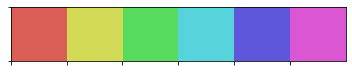

In [59]:
# Get those unique colors
cluster_color_values = sb.color_palette("hls",n_colors = len(df.cluster.unique()))#'HLS'

print(sorted(df.cluster.unique()))
# Display those unique colors
sb.palplot(sb.color_palette(cluster_color_values))


Store in a dictionary

In [60]:
cluster_color_dict = dict(zip(sorted(df.cluster.unique()), cluster_color_values))
cluster_color_dict

{1: (0.86, 0.3712, 0.33999999999999997),
 2: (0.8287999999999999, 0.86, 0.33999999999999997),
 3: (0.33999999999999997, 0.86, 0.3712),
 4: (0.33999999999999997, 0.8287999999999999, 0.86),
 5: (0.3712, 0.33999999999999997, 0.86),
 6: (0.86, 0.33999999999999997, 0.8287999999999999)}

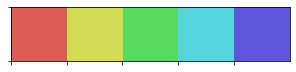

In [61]:
## Here is an example of how you might specify the values yourself,
# derived from the QC/EDA chapter. Note that in this case, our keys
# are not strings (e.g., '1'), but are actually ints (integers, e.g., 1).

#cluster_color_dict['1'] = mplc.to_rgb('xkcd:dark sky blue')
#cluster_color_dict['2'] = mplc.to_rgb('xkcd:reddish orange')
#cluster_color_dict['3'] = mplc.to_rgb('xkcd:jungle green')


sb.palplot(sb.color_palette(
    [cluster_color_dict[1],
     cluster_color_dict[2],
     cluster_color_dict[3],
    cluster_color_dict[4],
    cluster_color_dict[5]]))


#### Save color information (mapping and legend) to metadata directory

In [62]:
# Create dataframe
cluster_color_df = color_dict_to_df(cluster_color_dict, "cluster")
cluster_color_df.head()

# Save to file in metadatadirectory
filename = "cluster_color_data.csv"
filename = os.path.join(metadata_dir, filename)
cluster_color_df.to_csv(filename, index = False)

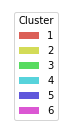

In [63]:
# Legend of cluster info only

g  = plt.figure(figsize = (1,1)).add_subplot(111)
g.axis('off')
handles = []
for item in sorted(cluster_color_dict.keys()):
        h = g.bar(0,0, color = cluster_color_dict[item],
                  label = item, linewidth =0)
        handles.append(h)
first_legend = plt.legend(handles=handles, loc='upper right', title = 'Cluster'),


filename = "Clustertype_legend.png"
filename = os.path.join(metadata_images_dir, filename)
plt.savefig(filename, bbox_inches = 'tight')

### Heatmap

Here, I assume we have clustering data for the full df loaded in for this chapter, not just a subset of ~10k cells, regardless of how many rows of our df were used to determine the best K. If we *are* working with a subsetted df at this point, then the below method to get a subset appropriate for the heatmap will still work fine.

We will only be plotting ~10k cells in the interest of time/computing resources. We want these 10k lines in our original df to be sampled randomly, without replacement, with the caveat that the proportions of all samples in the data remains the same in this subset. If the size of the dataframe is > 10k rows, then we will proceed with the entire dataset.

In [64]:
heatmap_row_count = min(10000, df.shape[0])

In [65]:
# Create df of each feature type, its proportion in the full df,
# and the number of rows we want for a sum of heatmap_row_count rows
counts_for_heatmap = create_equal_value_counts(df, 'Sample_ID',heatmap_row_count)
counts_for_heatmap

,current_row_count,prop,desired_row_count
A_GZ2,66137,0.110035,1429.0
B_GZ1,1443,0.002401,1429.0
C_GZ5,185,0.000308,185.0
D_GZ4,47135,0.078420,1429.0
E_GZ3,5502,0.009154,1429.0
F_GZ6,54962,0.091442,1429.0
G_GZ7,425692,0.708240,1429.0


In [67]:
# Create new df to hold our heatmap data
heatmap_data = pd.DataFrame(columns = df.columns)

# populate the df
for sample in df.Sample_ID.unique():
    a = counts_for_heatmap.loc[counts_for_heatmap.index == sample,'current_row_count'].values[0]
    size = int(counts_for_heatmap.loc[counts_for_heatmap.index == sample,'desired_row_count'].values[0])
    random_rows = np.random.choice(a = a, size = size, replace = False)
    df_sample = df.loc[df['Sample_ID'] == sample,:]
    heatmap_data = heatmap_data.append(df_sample.iloc[random_rows,:])

In [69]:
## We want to make sure our sampling worked as expected.

# In our new dataframe, how many rows do we actually have for each sample?
# What is the proportion of each sample's rows of the total dataframe?

# Compare this with the 'counts_for_heatmap' above
# Note there might be slight differences in 'prop' due to rounding

create_equal_value_counts(heatmap_data, 'Sample_ID', heatmap_data.shape[0])

,current_row_count,prop,desired_row_count
A_GZ2,1429,0.163146,1251.0
B_GZ1,1429,0.163146,1251.0
C_GZ5,185,0.021121,185.0
D_GZ4,1429,0.163146,1251.0
E_GZ3,1429,0.163146,1251.0
F_GZ6,1429,0.163146,1251.0
G_GZ7,1429,0.163146,1251.0


Unlike other heatmaps in the workflow, this one will not use row clustering. We want to arrange the rows first by cluster number and then by Sample_ID.

In [70]:
heatmap_data = heatmap_data.sort_values(by = ['cluster','Sample_ID'])

Get data structures to map colors to columns and rows...

In [71]:
sample_row_colors = heatmap_data.Sample_ID.map(sample_color_dict)

sample_row_colors[1:5]

E_GZ3_Cell_15913    (0.20125317221201128, 0.6907920815379025, 0.47...
E_GZ3_Cell_15627    (0.20125317221201128, 0.6907920815379025, 0.47...
E_GZ3_Cell_12666    (0.20125317221201128, 0.6907920815379025, 0.47...
E_GZ3_Cell_39648    (0.20125317221201128, 0.6907920815379025, 0.47...
Name: Sample_ID, dtype: object

In [72]:
row_celltype_colors = heatmap_data.cell_type.map(celltype_color_dict)

row_celltype_colors[1:5]

E_GZ3_Cell_15913    (0.3712, 0.33999999999999997, 0.86)
E_GZ3_Cell_15627    (0.86, 0.3712, 0.33999999999999997)
E_GZ3_Cell_12666    (0.86, 0.3712, 0.33999999999999997)
E_GZ3_Cell_39648    (0.33999999999999997, 0.86, 0.3712)
Name: cell_type, dtype: object

In [73]:
row_cluster_colors = heatmap_data.cluster.map(cluster_color_dict)

row_cluster_colors[1:5]

E_GZ3_Cell_15913    (0.86, 0.3712, 0.33999999999999997)
E_GZ3_Cell_15627    (0.86, 0.3712, 0.33999999999999997)
E_GZ3_Cell_12666    (0.86, 0.3712, 0.33999999999999997)
E_GZ3_Cell_39648    (0.86, 0.3712, 0.33999999999999997)
Name: cluster, dtype: object

In [79]:
pd.Series(
    heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values).head()

0    53BP1
1      AXL
2    CCNA2
3    CCND1
4      CD4
dtype: object

In [ ]:
metadata['full']

In [81]:
column_channel_colors = pd.merge(pd.DataFrame(pd.Series(
    heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values)), 
                  metadata, how = 'left',
         left_on = 0, right_on = 'full_column')[[0,'Channel']]['Channel'].map(channel_color_dict)


column_channel_colors.index = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values

column_channel_colors.head()

53BP1    (0.25098039215686274, 0.8784313725490196, 0.81...
AXL                         (1.0, 0.6470588235294118, 0.0)
CCNA2                       (1.0, 0.6470588235294118, 0.0)
CCND1                                      (1.0, 0.0, 0.0)
CD4                                        (1.0, 0.0, 0.0)
Name: Channel, dtype: object

In [82]:
column_round_colors = pd.merge(pd.DataFrame(pd.Series(
    heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values)), 
                  metadata, how = 'left',
         left_on = 0, right_on = 'full_column')[[0,'Round']]['Round'].map(round_color_dict)


column_round_colors.index = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)].columns.values

column_round_colors.head()

53BP1    (0.3736023974468758, 0.214424058315835, 0.3978...
AXL      (0.4347275623260717, 0.45841778084048856, 0.66...
CCNA2    (0.3736023974468758, 0.214424058315835, 0.3978...
CCND1    (0.4347275623260717, 0.45841778084048856, 0.66...
CD4      (0.4159341362257507, 0.3236230119238674, 0.552...
Name: Round, dtype: object

In [101]:
# Create data structure to hold everything we need for row/column annotations
# annotations is a dictionary
## IMPORTANT - if you use 'annotations', it MUST have both 'rows' and 'cols'
## objects inside. These can be empty lists, but they must be there!
anns = {}

# create a data structure to hold everything we need for only row annotations
# row_annotations is a list, where each item therein is a dictioary corresponding
# to all of the data pertaining to that particular annotation
# Adding each item (e.g., Sample, then Cluster), one at a time to ensure ordering
# is as anticipated on figure
row_annotations = []
row_annotations.append({'label':'Sample','type':'row','mapping':sample_row_colors,'dict':sample_color_dict,
                        'location':'center left','bbox_to_anchor':(0, 0.5)})
row_annotations.append({'label':'Cell type','type':'row','mapping':row_celltype_colors,
                        'dict':celltype_color_dict,
                        'location':'lower left','bbox_to_anchor':(0, 0.65)})
row_annotations.append({'label':'Cluster','type':'row','mapping':row_cluster_colors,
                        'dict':cluster_color_dict,
                        'location':'lower left','bbox_to_anchor':(0, 0.20)})
# Add all row information into the annotations dictionary
anns['rows'] = row_annotations


# Now we repeat the process for column annotations
col_annotations = []
col_annotations.append({'label':'Round','type':'column','mapping':column_round_colors,'dict':round_color_dict,
                       'location':'upper right','bbox_to_anchor':(1,0.50)})

col_annotations.append({'label':'Column','type':'column','mapping':column_channel_colors,'dict':channel_color_dict,
                       'location':'upper right','bbox_to_anchor':(1,0.75)})
anns['cols'] = col_annotations

#### Actually plot the heatmap

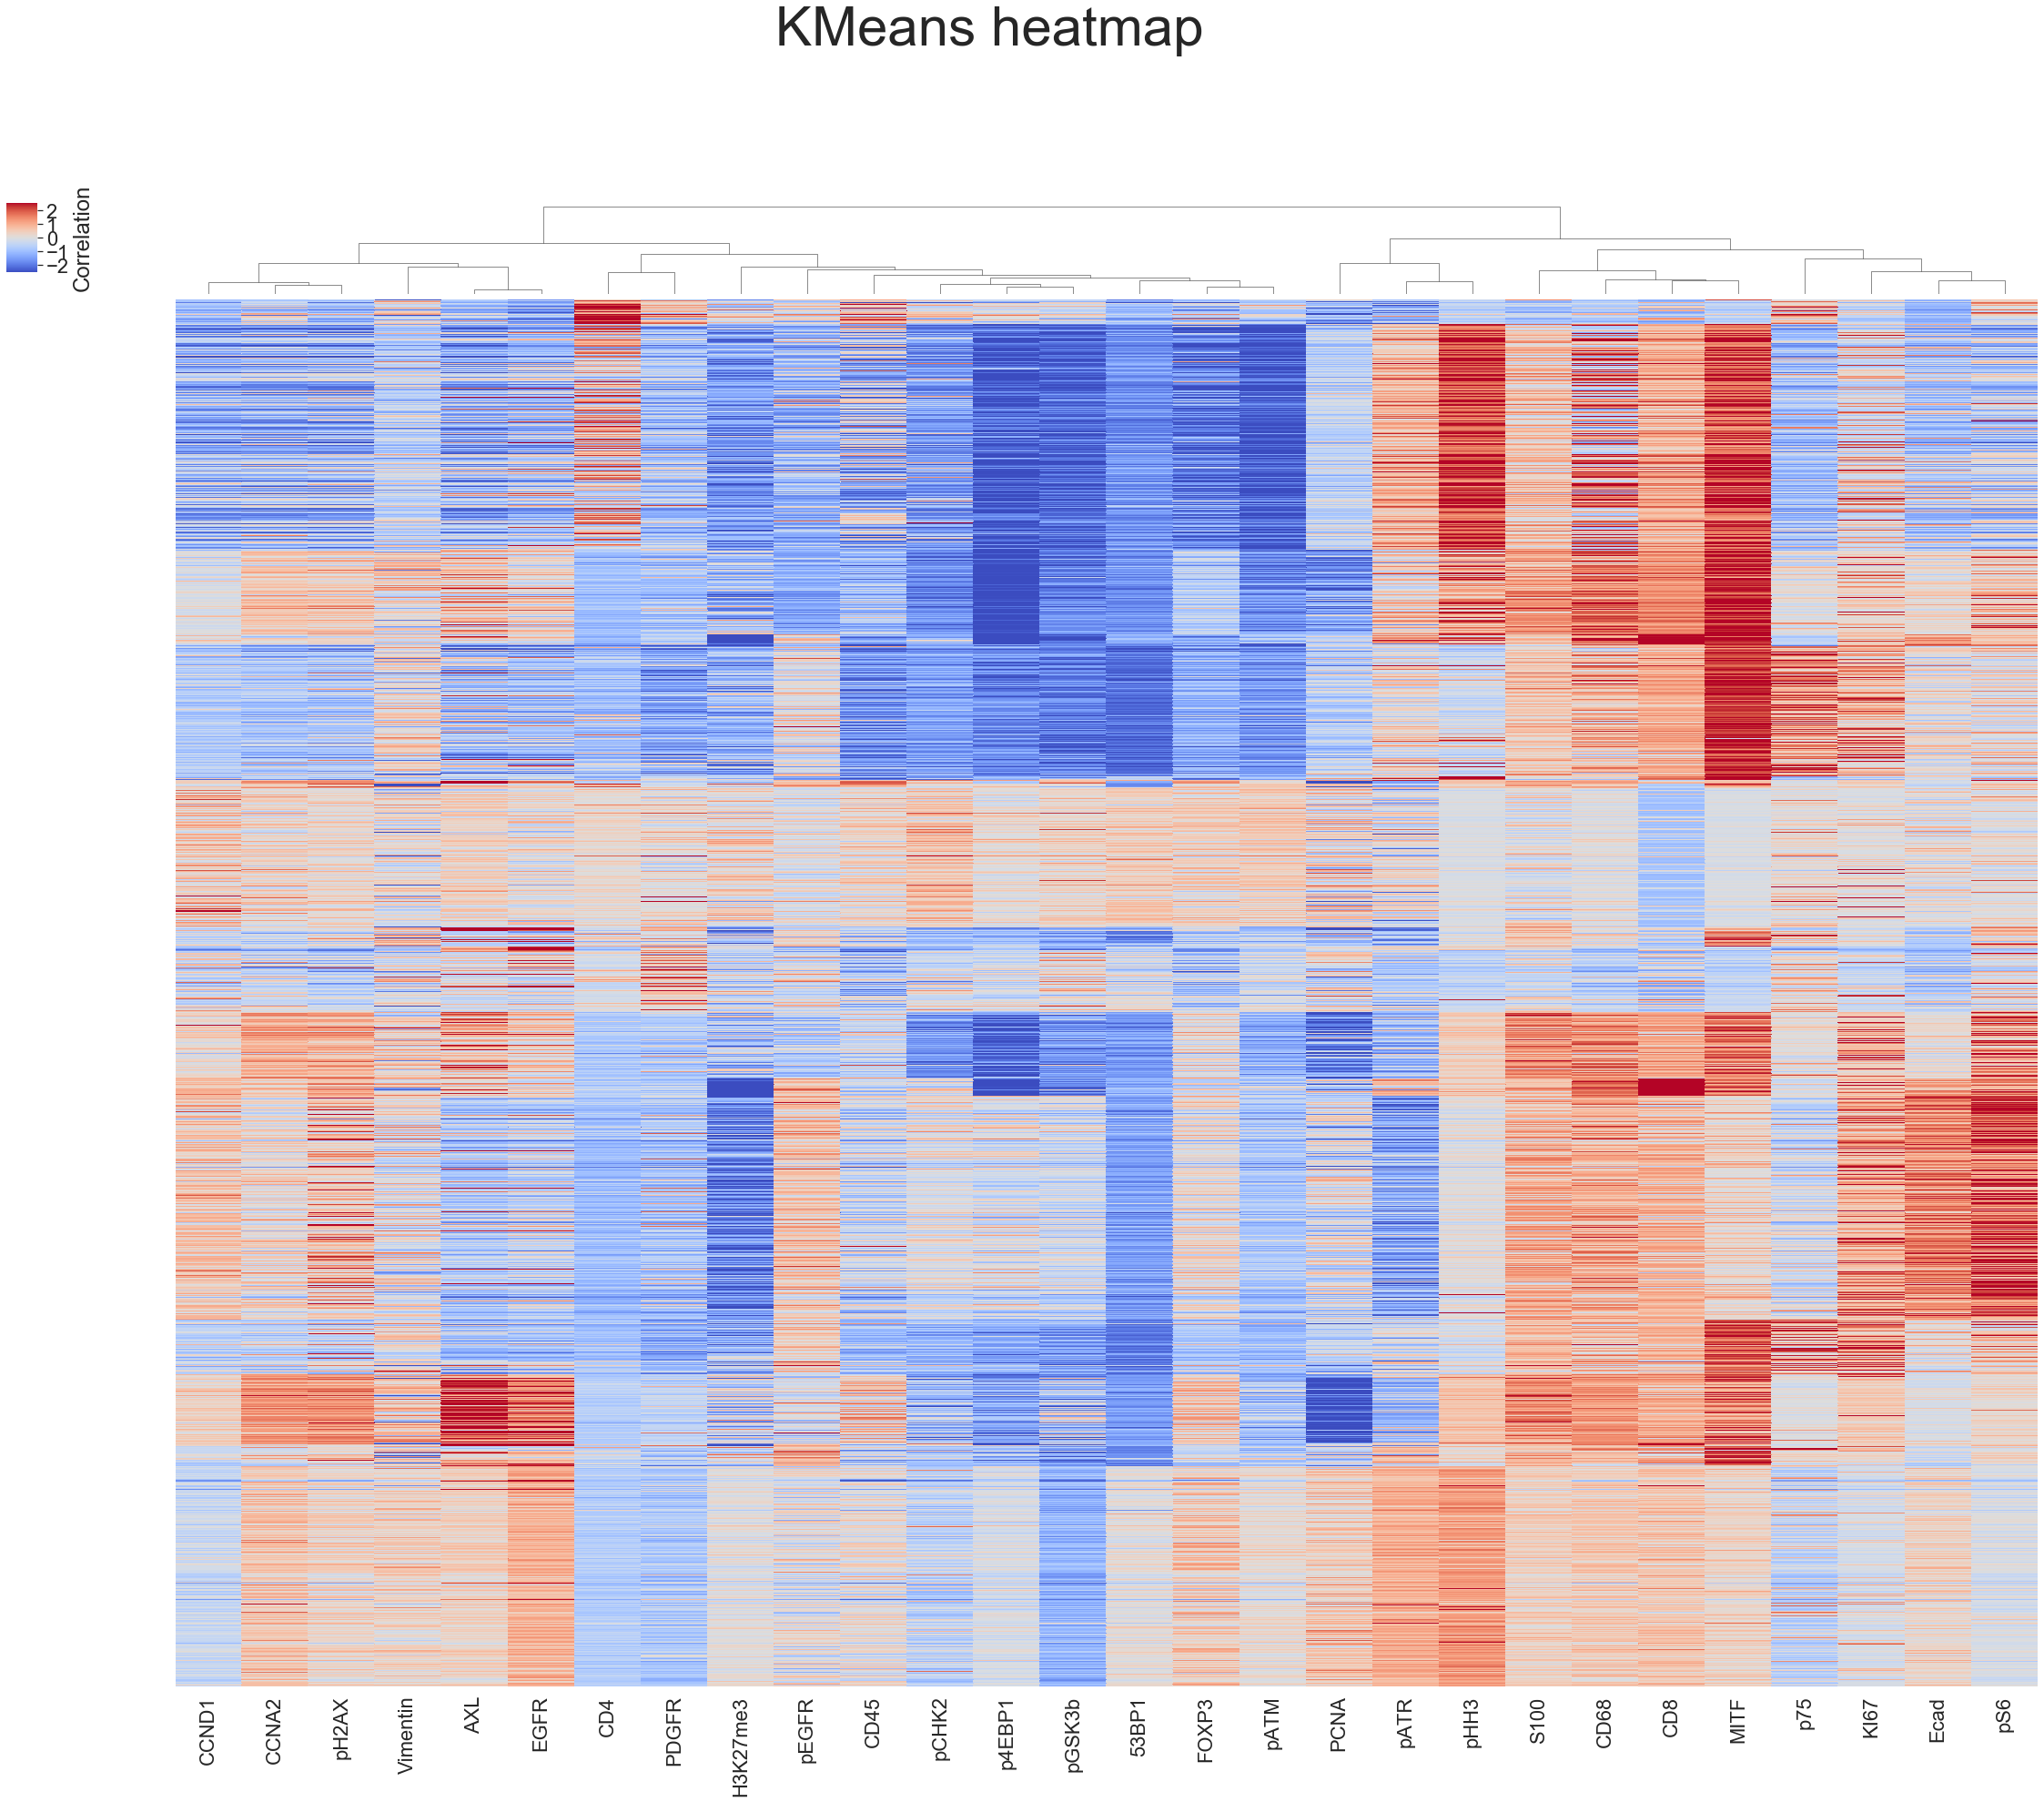

In [103]:
heatmap_function(data = heatmap_data.loc[:,~heatmap_data.columns.isin(not_intensities)],
    title = "KMeans heatmap",
               # define method, metric, and color map
          method = 'ward', metric = 'correlation',cmap = 'coolwarm',
               # colorbar (legend coloring of main plot) 
               cbar_kws = {'label':'Correlation'},
               # xticklabels - want to have the nicknames instead of full names
                xticklabels = [name for name in
                 #xticklabels = [full_to_short_names[name] for name in 
                     heatmap_data.loc[:,
                                 ~heatmap_data.columns.isin(not_intensities)].columns.values],
                 save_loc = output_images_dir,
                 row_cluster = False, col_cluster = True,
                    annotations = anns
          )

### XY Maps

In [98]:
# Plot one XY map for each sample, where each cluster is a different color

# iterate through all samples
for sample in ls_samples:
    location_colors = df.loc[df['Sample_ID'] == sample,['Nuc_X_Inv','Nuc_Y_Inv','cluster']]

    fig = go.Figure()
    
    title = sample
    
    # Iterate through all unique cluster values assocaited with this sample
    # Not every cluster may be present in every sample
    for cluster in sorted(df.loc[df['Sample_ID'] == sample,'cluster'].unique()):
        fig.add_scatter(
            mode = 'markers',
            marker=dict(
                size=5, opacity=0.4, # size is dot size, higher opacity = less opaque
                color='rgb' + str(cluster_color_dict[cluster])#,
                #line = dict(width = 2, color = 'gray') # line around each marker
            ),
        x = location_colors.loc[location_colors['cluster']==cluster,'Nuc_X_Inv'],
        y = location_colors.loc[location_colors['cluster']==cluster,'Nuc_Y_Inv'],
        name = "Cluster " + str(cluster))


    fig.update_layout(title = title, plot_bgcolor = 'white', showlegend = True,
                     legend= {'itemsizing': 'constant'}) # make the legend dots a bit bigger
    fig.update_xaxes(title_text = 'Nuc_X_Inv', linecolor = 'black')
    fig.update_yaxes(title_text = 'Nuc_Y_Inv', linecolor = 'black')


    #plot(fig)
    filename = sample + " KMeans XY Map with " + str(n_clusters) + " clusters.png"
    filename = filename.replace(" ", "_")
    filename = os.path.join(output_images_dir, filename)
    fig.write_image(filename)



ValueError: 
For some reason plotly.py was unable to communicate with the
local orca server process, even though the server process seems to be running.

Please review the process and connection information below:

orca status
-----------
    state: running
    executable: /Users/groutm/anaconda3/bin/orca
    version: 1.2.1
    port: 61483
    pid: 16680
    command: ['/Users/groutm/anaconda3/bin/orca', 'serve', '-p', '61483', '--plotly', '/Users/groutm/anaconda3/lib/python3.7/site-packages/plotly/package_data/plotly.min.js', '--graph-only', '--mathjax', 'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js']




### Bar plots

#### Bar plot - counts of cells in each cluster

In [88]:
cluster_counts = pd.DataFrame(columns = ['clusternum','clustername','clustername_full','count'])

df.loc[df['cluster'] == 1,:].shape[0]

for c in range(1,n_clusters+1):
    cluster_counts = cluster_counts.append(pd.DataFrame(
        {'clusternum':[c],
         'clustername':['Cl ' + str(c)],
         'clustername_full':['Cluster ' + str(c)],
         'count':[df.loc[df['cluster'] == c,:].shape[0]]}))
    
    
cluster_counts.index = range(cluster_counts.shape[0])

cluster_counts.head()

,clusternum,clustername,clustername_full,count
0,1,Cl 1,Cluster 1,42647
1,2,Cl 2,Cluster 2,72611
2,3,Cl 3,Cluster 3,257656
3,4,Cl 4,Cluster 4,124267
4,5,Cl 5,Cluster 5,48609


In [89]:
# By Cluster only

fig = go.Figure()
title = 'KMeans cluster cell counts'

for c in sorted(df.cluster.unique()):
    fig.add_trace(go.Bar(
        x=cluster_counts.loc[cluster_counts['clusternum']==c,'clustername'], 
        y = cluster_counts.loc[cluster_counts['clusternum']==c,'count'],
        text = cluster_counts.loc[cluster_counts['clusternum']==c,'count'], textposition= 'outside',
        marker=dict(
            color='rgb' + str(cluster_color_dict[c])),
            showlegend = False
        
    ))
fig.update_layout(title = title, plot_bgcolor = 'white')
fig.update_xaxes(linecolor = 'black')
fig.update_yaxes(title_text = "Cells", linecolor = 'black')
#plot(fig)

filename = title.replace(" ","_") + ".png"
filename = os.path.join(output_images_dir, filename)
fig.write_image(filename)


#### Bar plot - Proportional and count breakdowns of tissue type within each cluster

In [90]:
cluster_counts

,clusternum,clustername,clustername_full,count
0,1,Cl 1,Cluster 1,42647
1,2,Cl 2,Cluster 2,72611
2,3,Cl 3,Cluster 3,257656
3,4,Cl 4,Cluster 4,124267
4,5,Cl 5,Cluster 5,48609
5,6,Cl 6,Cluster 6,55266


In [91]:
cluster_counts['stroma'] = cluster_counts.apply(lambda row: 
    df.loc[(df['cluster'] == row['clusternum']) &
             (df['cell_type'] == 'STROMA'),:].shape[0] , axis = 1)

cluster_counts['immune'] = cluster_counts.apply(lambda row: 
    df.loc[(df['cluster'] == row['clusternum']) &
             (df['cell_type'] == 'IMMUNE'),:].shape[0] , axis = 1)

cluster_counts['cancer'] = cluster_counts.apply(lambda row: 
    df.loc[(df['cluster'] == row['clusternum']) &
             (df['cell_type'] == 'CANCER'),:].shape[0] , axis = 1)

cluster_counts['stroma_perc'] = cluster_counts.apply(
    lambda row: round(row['stroma']/row['count']*100,1) , axis = 1)

cluster_counts['immune_perc'] = cluster_counts.apply(
    lambda row: round(row['immune']/row['count']*100,1) , axis = 1)

cluster_counts['cancer_perc'] = cluster_counts.apply(
    lambda row: round(row['cancer']/row['count']*100,1) , axis = 1)

In [92]:
cluster_counts

,clusternum,clustername,clustername_full,count,stroma,immune,cancer,stroma_perc,immune_perc,cancer_perc
0,1,Cl 1,Cluster 1,42647,21238,8481,12928,49.8,19.9,30.3
1,2,Cl 2,Cluster 2,72611,36317,14635,21659,50.0,20.2,29.8
2,3,Cl 3,Cluster 3,257656,128659,51548,77449,49.9,20.0,30.1
3,4,Cl 4,Cluster 4,124267,62336,24693,37238,50.2,19.9,30.0
4,5,Cl 5,Cluster 5,48609,24312,9647,14650,50.0,19.8,30.1
5,6,Cl 6,Cluster 6,55266,27927,10790,16549,50.5,19.5,29.9


In [93]:
# Cell type within cluster - count


fig = go.Figure()
title = 'KMeans cell types count within clusters'

fig = go.Figure(data=[
    go.Bar(name='Stroma', x=cluster_counts['clustername'], y=cluster_counts['stroma'], 
           text = cluster_counts['stroma'], textposition='auto',
           marker_color = 'rgb' + str(celltype_color_dict['STROMA'])),
    
    go.Bar(name='Immune', x=cluster_counts['clustername'], y=cluster_counts['immune'], 
           text = cluster_counts['immune'], textposition='auto',
           marker_color = 'rgb' + str(celltype_color_dict['IMMUNE'])),
    
    go.Bar(name='Cancer',x=cluster_counts['clustername'], y=cluster_counts['cancer'], 
           text = cluster_counts['cancer'], textposition='auto', 
           marker_color = 'rgb' + str(celltype_color_dict['CANCER']))
])
    
fig.update_layout(title = title, plot_bgcolor = 'white',barmode ='stack')
fig.update_xaxes(linecolor = 'black')
fig.update_yaxes(title = "Cell count", linecolor = 'black')
#plot(fig)

filename = title.replace(" ","_") + ".png"
filename = os.path.join(output_images_dir, filename)
fig.write_image(filename)

In [94]:
# Cell type within cluster - proportional

fig = go.Figure()
title = 'KMeans cell types proportions within clusters'

fig = go.Figure(data=[
    go.Bar(name='Stroma', x=cluster_counts['clustername'], y=cluster_counts['stroma_perc'], 
           text = cluster_counts['stroma_perc'], textposition='auto',
           marker_color = 'rgb' + str(celltype_color_dict['STROMA'])),
    
    go.Bar(name='Immune', x=cluster_counts['clustername'], y=cluster_counts['immune_perc'], 
           text = cluster_counts['immune_perc'], textposition='auto',
           marker_color = 'rgb' + str(celltype_color_dict['IMMUNE'])),
    
    go.Bar(name='Cancer',x=cluster_counts['clustername'], y=cluster_counts['cancer_perc'], 
           text = cluster_counts['cancer_perc'], textposition='auto', 
           marker_color = 'rgb' + str(celltype_color_dict['CANCER']))
])
    
fig.update_layout(title = title, plot_bgcolor = 'white',barmode ='stack')
fig.update_xaxes(linecolor = 'black')
fig.update_yaxes(title = "Cell proportion of total", linecolor = 'black')
#plot(fig)

filename  = title.replace(" ","_") + ".png"
filename = os.path.join(output_images_dir, filename)
fig.write_image(filename)


### Distributions


Boxplots distributions
On Kmeans clusters – one plot per marker, each box is a cluster, all samples in there


In [95]:
# By sample ID and cell type
def make_cluster_boxplot(my_marker, df):
    fig = go.Figure()
    title = 'KMeans ' + my_marker + ' Distributions by cluster'

    clusters = sorted(df.cluster.unique())
    data = []
    for c in clusters:
        data.append(go.Box(name="Cl "+str(c),
                           y = df.loc[df['cluster']==c,my_marker],
                          marker = dict(color = 'rgb'+str(cluster_color_dict[c]))))

    fig = go.Figure(data=data)
    fig.update_layout(title = title, plot_bgcolor = 'white',barmode ='stack', showlegend = False)
    fig.update_xaxes(linecolor = 'black')
    fig.update_yaxes(title_text = 'Z-Scored Intensity', linecolor = 'black')
    #plot(fig)
    
    filename = title.replace(" ","_") + ".png"
    filename = os.path.join(output_images_dir, filename)
    fig.write_image(filename)
    return None


In [96]:
df = df.rename(columns = full_to_short_names)

for m in [m for m in df.columns.values if m not in not_intensities]:
    pass
    make_cluster_boxplot(m, df)

df = df.rename(columns = short_to_full_names)

### Calculate the percentage/proportion of each cluster for each sample

This information will be used in a few subsequent visualizations, as well as saved for future reference. One important thing to note about these dataframes is that Sample_ID is the name of the index, and the values of the index are our sample names. This is how the dfs are generated, and I've chosen to keep them that way because it will make it a bit easier for the median value heatmap later on. Note that the bar plot will gather its x-axis data from the index of a dataframe. Both the index (Sample_ID) and columns (cluster) are going to be named, which might make the dfs look a little unusual when printed to the screen.

First, we create a dataframe of the counts for each sample/cluster combination.

In [236]:
# Group by Sample_ID, then get the value counts for each cluster,
# then massage into a dataframe
cluster_sample_counts = df.groupby('Sample_ID')['cluster'].value_counts().unstack().fillna(0)

## Keeping some commented out code in case we want to make 'Sample_ID' a column in its own right
#cluster_sample_counts['Sample_ID'] = cluster_sample_counts.index

## Change from floats to ints
#cluster_sample_counts.loc[:,cluster_sample_counts.columns != 'Sample_ID'] = \
#    cluster_sample_counts.loc[:,cluster_sample_counts.columns != 'Sample_ID'].astype(int)
cluster_sample_counts = cluster_sample_counts.astype(int)

In [237]:
cluster_sample_counts.head()

# Note 'Sample_ID' is name of index, 'cluster' is name of columns.

cluster,1,2,3,4,5
Sample_ID,,,,,
GZ10.1,38,4,3061,3,11
GZ10.2,331,26,2190,112,6
GZ10.3,795,227,5920,92,16
GZ6,254,47716,364,577,0
GZ7.1,7434,7,10,1715,411


We are also interested in the proportion values.

In [238]:
## Proportions
cluster_sample_props = cluster_sample_counts.copy()

# Keeping some commented out code in case we've chosen
# to make 'Sample_ID' a column in its own right
"""cluster_sample_props.loc[:,
    cluster_sample_props.columns != 'Sample_ID'] = \
        cluster_sample_props.loc[:,cluster_sample_props.columns != 'Sample_ID'].apply(
            lambda row: round(row/row.sum()*100,1), axis =1)"""
cluster_sample_props = \
        cluster_sample_props.apply(
            lambda row: round(row/row.sum()*100,1), axis =1)

In [239]:
cluster_sample_props.head()

# Note 'Sample_ID' is name of index, 'cluster' is name of columns.

cluster,1,2,3,4,5
Sample_ID,,,,,
GZ10.1,1.2,0.1,98.2,0.1,0.4
GZ10.2,12.4,1.0,82.2,4.2,0.2
GZ10.3,11.3,3.2,84.0,1.3,0.2
GZ6,0.5,97.6,0.7,1.2,0.0
GZ7.1,77.6,0.1,0.1,17.9,4.3


Save files of these two dataframes.

In [240]:
## Counts
filename = "sample_cluster_counts.csv"
filename = os.path.join(output_data_dir, filename)
cluster_sample_counts.to_csv(filename, index = True, 
                             # We want the header of the output file to have the format 'cluster_#' instead of '#'
                             ## Keeping some commented out code in case we have decided to make 'Sample_ID' a column in its own right
                             # We also do not want to alter the name of the 'Sample_ID' column
                             #header = ["cluster_" + str(c) for c in cluster_sample_counts.columns if c != 'Sample_ID'] +\
                             #        ['Sample_ID'])
                            header = ["cluster_" + str(c) for c in cluster_sample_counts.columns])
# Proportions
filename = "sample_cluster_counts_perc.csv"
filename = os.path.join(output_data_dir, filename)
cluster_sample_props.to_csv(filename, index = True,
                            # We want the header of the output file to have the format 'cluster_#' instead of '#'
                            ## Keeping some commented out code in case we have decided to make 'Sample_ID' a column in its own right
                             # We also do not want to alter the name of the 'Sample_ID' column
                             #header = ["cluster_" + str(c) for c in cluster_sample_counts.columns if c != 'Sample_ID'] +\
                             #        ['Sample_ID'])
                            header = ["cluster_" + str(c) for c in cluster_sample_counts.columns])

### Bar plot - Proportional breakdown of clusters within sample

In [241]:
# By sample ID and cell type

fig = go.Figure()
title = 'Proportional breakdown of clusters within sample'

clusters = list(range(1,n_clusters+1))
data = []
for c in clusters:
    data.append(go.Bar(name="Cl "+str(c),
                       x=cluster_sample_counts.index, # if 'Sample_ID' were a column, we would have said cluster_sample_counts['Sample_ID']
                       y=cluster_sample_counts[c],
                       marker = dict(
                           color='rgb' + str(cluster_color_dict[c]))))

fig = go.Figure(data=data)
    
fig.update_layout(title = title, plot_bgcolor = 'white',barmode ='stack')
fig.update_xaxes(linecolor = 'black')
fig.update_yaxes(title_text = "Cluster proportion", linecolor = 'black')
#plot(fig)

filename = title.replace(" ","_") + ".png"
filename = os.path.join(output_images_dir, filename)
fig.write_image(filename)


### Prepare for median value heatmap

For this, we will want to combine rows in `cluster_sample_counts` at will, using whichever criteria we chose. The added rows will be replaced with one sum row. Then, we will determine the proportions and only plot the samples/data we are interested in.

First, let's create a copy of the `cluster_sample_counts` to work with. We want to maintain the original, so that we can create as many different combinations of rows as we want without extra work to revert back to the original.

In [242]:
counts_subset = cluster_sample_counts.copy()

counts_subset.head()

cluster,1,2,3,4,5
Sample_ID,,,,,
GZ10.1,38,4,3061,3,11
GZ10.2,331,26,2190,112,6
GZ10.3,795,227,5920,92,16
GZ6,254,47716,364,577,0
GZ7.1,7434,7,10,1715,411


In [243]:
def row_combiner(df, drop_rows, new_name):
    # Check that drop_rows are in the index
    if len(set(drop_rows).intersection(set(df.index))) == 0:
        print("1+ item(s) specified for dropping not found in dataframe's index.")
        print("Returning unaltered dataframe.")
        return df
    
    # First create a dataframe consisiting of the chosen summed rows
    # Note that we are feeding a list of index identifiers into
    # the .index.isin() portion
    new_row = pd.DataFrame( # make a df out of the following...
    counts_subset.loc[ # only the rows where given df has rows meeting criteria
                    # criteria are that index identifiers are in the given list
        df.index.isin(drop_rows),
        # all columns are wanted, hence the ":"
        # We are also summming along the first (0th index) axis, along the rows
        :].sum(axis = 0)
            ).T # transpose to get a row instead of a column

    # In order to replace the summed rows with our new row,
    # we will need to assign our new row an index identifier
    # This should be the identifier you want to see on the median
    # value heatmap.
    new_row.index = [new_name]

    # We will also rename the axis to 'Sample_ID', as before,
    # or else the counts_subset will lose its axis name when
    # the new row is added
    new_row = new_row.rename_axis(df.index.name, axis = 'index')

    # What does this new dataframe look like?
    # Remember 'cluster' is just the name of the columns
    
    df = df.append(new_row)
    df = df.drop(drop_rows)

    return df

In [261]:
counts_subset = \
    row_combiner(df = counts_subset, drop_rows = ['GZ10.1','GZ10.2'], new_name = 'Patient_1')

counts_subset = \
    row_combiner(df = counts_subset, drop_rows = ['GZ7.1','GZ7.2'], new_name = 'Patient_2')

counts_subset

1+ item(s) specified for dropping not found in dataframe's index.
Returning unaltered dataframe.


cluster,1,2,3,4,5
Sample_ID,,,,,
GZ10.3,795,227,5920,92,16
GZ6,254,47716,364,577,0
Patient_1,369,30,5251,115,17
Patient_2,74025,192,871,46017,7366


You can repeat the above process as many times as you would like to add on as many rows as you would like. There are a few other manipulations to consider.

What if we want to drop some additional rows? The `drop()` function is fed a list of index identifiers to drop from the dataframe.

In [265]:
counts_subset.drop(['GZ6'])

cluster,1,2,3,4,5
Sample_ID,,,,,
GZ10.3,795,227,5920,92,16
Patient_1,369,30,5251,115,17
Patient_2,74025,192,871,46017,7366


What if we want to rename the index name? I will not write over `cluster_sample_counts`, but here is what you would do.

In [266]:
counts_subset.rename_axis('new_index_name',axis = 'index')

cluster,1,2,3,4,5
new_index_name,,,,,
GZ10.3,795,227,5920,92,16
GZ6,254,47716,364,577,0
Patient_1,369,30,5251,115,17
Patient_2,74025,192,871,46017,7366


What if we made a typo, and Patient_1 should be Patient_10? Again, I am not overwriting `counts_subset` unless I set it equal to this new expression.

In [267]:
counts_subset.rename(index={'Patient_1':'Patient_10'})

cluster,1,2,3,4,5
Sample_ID,,,,,
GZ10.3,795,227,5920,92,16
GZ6,254,47716,364,577,0
Patient_10,369,30,5251,115,17
Patient_2,74025,192,871,46017,7366


What if we want to include one or more of our dropped rows? We can append those from the intact `counts_subset`. Here is what the resulting dataframe would look like.

In [268]:
counts_subset.append(cluster_sample_counts.loc[['GZ10.1'],:])

cluster,1,2,3,4,5
Sample_ID,,,,,
GZ10.3,795,227,5920,92,16
GZ6,254,47716,364,577,0
Patient_1,369,30,5251,115,17
Patient_2,74025,192,871,46017,7366
GZ10.1,38,4,3061,3,11


We also want to create a copy of our original dataframe to use for finding the medians. As before, we will be exchanging original sample labels with other labels. Unlike before, we will not be combining rows until the very end. Row renaming will occur more simply.

In [326]:
# Create a copy of the original df

for_medians = df.copy()

In [327]:
# Rename rows as necessary

for_medians.loc[for_medians['Sample_ID'].isin(['GZ10.1','GZ10.2']),['Sample_ID']] = \
    'Patient_1' 


for_medians.loc[for_medians['Sample_ID'].isin(['GZ7.1','GZ7.2']),['Sample_ID']] = \
    'Patient_2' 

for_medians.Sample_ID.unique()

array(['Patient_1', 'GZ10.3', 'Patient_2', 'GZ6'], dtype=object)

In [328]:
for_medians.loc[~for_medians['Sample_ID'].isin(['Patient_2', 'Patient_1']),['Sample_ID']].head()

,Sample_ID
GZ10.3_Cell_3,GZ10.3
GZ10.3_Cell_5,GZ10.3
GZ10.3_Cell_6,GZ10.3
GZ10.3_Cell_8,GZ10.3
GZ10.3_Cell_9,GZ10.3


In [329]:
# Drop rows as necessary 

# Drop everything that isn't 'Patient_1'
drop_indices = for_medians.loc[for_medians['Sample_ID'] != 'Patient_1',:].index

# Or maybe we want to drop everything that isn't 'Patient_1' or 'Patient_2'
drop_indices = for_medians.loc[~for_medians['Sample_ID'].isin(['Patient_2', 'Patient_1']),:].index

# The portion through "drop(drop_indices)" gives us a dataframe with the rows we don't want removed
for_medians = for_medians.drop(drop_indices)

Remember `for_medians` is just our regular df with the 'Sample_ID' label changed to reflect our groupings for the visualization.

In [335]:
for_medians.head()

,53BP1_Cell_Intensity_Average,AXL_Cell_Intensity_Average,CCNA2_Cell_Intensity_Average,CCND1_Cell_Intensity_Average,CD45_Cell_Intensity_Average,CD4_Cell_Intensity_Average,CD68_Cell_Intensity_Average,CD8_Cell_Intensity_Average,Cell_Size,EGFR_Cell_Intensity_Average,...,p75_Cell_Intensity_Average,pATM_Cell_Intensity_Average,pATR_Cell_Intensity_Average,pCHK2_Cell_Intensity_Average,pEGFR_Cell_Intensity_Average,pGSK3b_Cell_Intensity_Average,pH2AX_Cell_Intensity_Average,pHH3_Cell_Intensity_Average,pS6_Cell_Intensity_Average,cluster
GZ10.1_Cell_0,-0.313459,-1.490272,-1.908790,-0.030991,-0.941220,-1.310224,-2.356702,-0.599582,269,-2.376797,...,-0.600528,-1.295570,-0.157697,-0.202299,-0.470776,-0.516484,3.799354,1.446353,-1.842134,3
GZ10.1_Cell_1,-0.224284,-0.934921,-1.949701,0.532423,-0.368662,-1.107055,-1.929954,-0.309925,275,-1.636028,...,-0.661293,-0.768085,-0.074061,-0.007423,-0.154490,-0.408859,3.373923,1.650604,-1.296788,3
GZ10.1_Cell_2,-0.076372,-0.123388,-1.386587,0.602092,0.728197,-0.402504,-0.833136,-0.100044,350,-0.464833,...,0.067070,0.277743,0.210888,0.545117,0.638038,0.148099,0.581417,1.938810,-0.968799,3
GZ10.1_Cell_3,0.144388,0.357853,-1.470081,-0.153387,-0.132831,-0.629220,-1.362529,-0.441941,401,0.645337,...,-0.432479,-0.602506,-0.022230,0.034898,0.175696,-0.227726,-0.833045,1.461031,-1.060958,3
GZ10.1_Cell_5,-0.713853,-1.829997,-1.918342,-0.572318,-1.598074,-1.176421,-2.926279,-0.406564,297,-2.996690,...,-0.494123,-1.620609,0.368587,-0.325021,-0.827885,-0.598653,4.252290,2.725074,-1.934794,3


Now let's incorporate our cutoff. We want to avoid plotting any cluster that makes up less than *x*% of that subset of data. Now that we have counts across all samples we want to group together, we can calculate the proprotion of each cluster contribution to that grouping.

In [289]:
# Create a dataframe of the proportions.
# Note that the *100 part of the command means that
# we are dealing percentages, not proportions, so
# that's a bit of a misnomer

props_subset = \
        counts_subset.apply(
            lambda row: round(row/row.sum()*100,1), axis =1)

props_subset

cluster,1,2,3,4,5
Sample_ID,,,,,
GZ10.3,11.3,3.2,84.0,1.3,0.2
GZ6,0.5,97.6,0.7,1.2,0.0
Patient_1,6.4,0.5,90.8,2.0,0.3
Patient_2,57.6,0.1,0.7,35.8,5.7


In [291]:
# cutoff should be a percentage, not a proportion
cutoff = 5

# We will create a dataframe of boolean T/F
# values, signifying whether the value of a
# given grouping (row) and cluster (columns)
# meets the inclusion criteria
props_subset_bool = props_subset.apply(
    lambda row: row >= cutoff, axis = 1)

props_subset_bool

cluster,1,2,3,4,5
Sample_ID,,,,,
GZ10.3,True,False,True,False,False
GZ6,False,True,False,False,False
Patient_1,True,False,True,False,False
Patient_2,True,False,False,True,True


Let's go ahead and create our `medians` dataframe now. This will be a dataframe where each row represents the medians values for markers for each sample-cluster combination.

In [358]:
medians.columns[medians.columns.isin(not_intensities)].values

array(['Cell_Size', 'Nuc_X', 'Nuc_X_Inv', 'Nuc_Y', 'Nuc_Y_Inv',
       'Nucleus_Size', 'ROI_index'], dtype=object)

In [359]:
# first group by our features of interest
medians = for_medians.copy().groupby(['Sample_ID','cluster']).median()

# then drop all columns that are not markers
medians = medians.drop(columns = medians.columns[medians.columns.isin(not_intensities)].values)


In [360]:
# Visualize medians
medians.head()

53BP1_Cell_Intensity_Average  AXL_Cell_Intensity_Average  \
Sample_ID cluster                                                             
Patient_1 1                           -0.031962                   -0.060462   
          2                           -0.243953                   -0.005985   
          3                           -0.468448                   -1.051417   
          4                           -0.308485                   -0.016867   
          5                           -0.397636                   -0.509891   

                   CCNA2_Cell_Intensity_Average  CCND1_Cell_Intensity_Average  \
Sample_ID cluster                                                               
Patient_1 1                           -0.862143                      0.929612   
          2                           -0.815442                      0.554049   
          3                           -1.774718                      0.585847   
          4                           -1.223605                      1.078379   
          5                           -1.703144                      0.079274   

                   CD45_Cell_Intensity_Average  CD4_Cell_Intensity_Average  \
Sample_ID cluster                                                            
Patient_1 1                           0.610899                   -0.115217   
          2                           0.287237                   -0.200906   
          3                           0.318270                   -0.464545   
          4                          -0.051843                   -0.148371   
          5                           1.273371                    1.561943   

                   CD68_Cell_Intensity_Average  CD8_Cell_Intensity_Average  \
Sample_ID cluster                                                            
Patient_1 1                          -0.120079                   -0.168531   
          2                          -0.050600                    0.160717   
          3                          -1.182732                    0.201957   
          4                          -0.685036                   -0.308844   
          5                          -0.164632                    0.350445   

                   EGFR_Cell_Intensity_Average  Ecad_Cell_Intensity_Average  \
Sample_ID cluster                                                             
Patient_1 1                          -0.313190                    -0.740761   
          2                          -0.346085                    -0.685195   
          3                          -1.351294                    -1.213925   
          4                          -0.462385                    -1.055158   
          5                          -1.119041                    -1.234955   

                   ...  p4EBP1_Cell_Intensity_Average  \
Sample_ID cluster  ...                                  
Patient_1 1        ...                       0.718832   
          2        ...                       0.203331   
          3        ...                      -0.521216   
          4        ...                      -0.277508   
          5        ...                       0.454990   

                   p75_Cell_Intensity_Average  pATM_Cell_Intensity_Average  \
Sample_ID cluster                                                            
Patient_1 1                          0.979890                     0.368281   
          2                          0.497410                     0.303771   
          3                          0.449299                    -0.688386   
          4                          1.906685                    -0.172934   
          5                          0.654630                    -0.703473   

                   pATR_Cell_Intensity_Average  pCHK2_Cell_Intensity_Average  \
Sample_ID cluster                                                              
Patient_1 1                          -1.017380                      0.411211   
          2                          -0.264099                

What we have here is a multiindex dataframe. We have two layers of row indexing, `Sample_ID` and `cluster`.

Using `medians` and `props_subset_bool`, drop all indices in `medians` where the sample-cluster combination does not meet our proportion threshold cutoff

In [396]:
drop_indices = []
# iterate through first five rows in medians
for i in range(5):
    print(medians.iloc[i,:].name)
    # extract the sample and cluster IDs from that row
    sample = medians.iloc[i,:].name[0]
    cluster = medians.iloc[i,:].name[1]
    # using those sample and cluster IDs, look inside props_subset_bool
    # look at the value specified by the correct sample and cluster col/row
    # that T/F value therein indicates whether this cluster should be used
    # with this sample
    use = props_subset_bool.loc[props_subset_bool.index == sample, props_subset_bool.columns == cluster].values[0][0]
    if not use:
        drop_indices.append(medians.iloc[i,:].name)

print("Dropping the following patient/cluster data from plotting due to proportion threshold failure: " + str([i for i in drop_indices]))
medians = medians.drop(drop_indices)

('Patient_1', 1)
('Patient_1', 2)
('Patient_1', 3)
('Patient_1', 4)
('Patient_1', 5)
Dropping the following patient/cluster data from plotting due to proportion threshold failure: [('Patient_1', 2), ('Patient_1', 4), ('Patient_1', 5)]


In [404]:
# Save output to a dataframe

filename = "medians_patient_1_patient_2.csv"
filename = os.path.join(output_data_dir, filename)
medians.to_csv(filename, index = True)

### Median value heatmap

In [409]:
# rename `medians` columns for plotting
medians = medians.rename(columns = full_to_short_names)
medians

53BP1       AXL     CCNA2     CCND1      CD45       CD4  \
Sample_ID cluster                                                               
Patient_1 1       -0.031962 -0.060462 -0.862143  0.929612  0.610899 -0.115217   
          3       -0.468448 -1.051417 -1.774718  0.585847  0.318270 -0.464545   
Patient_2 1        0.515818  0.188222  0.278210  0.665072  0.517189  0.784241   
          2        0.042837 -0.057661  0.581929 -0.265149 -0.314218  0.415998   
          3       -1.185660 -1.225096 -0.154507 -1.219907 -1.559810  0.069224   
          4       -0.001006 -0.287960 -0.051135  0.395293 -0.584892  0.283525   
          5       -1.213474 -1.052838 -0.165091 -0.907102  1.210486  3.390390   

                       CD68       CD8      EGFR      Ecad  ...    p4EBP1  \
Sample_ID cluster                                          ...             
Patient_1 1       -0.120079 -0.168531 -0.313190 -0.740761  ...  0.718832   
          3       -1.182732  0.201957 -1.351294 -1.213925  ... -0.521216   
Patient_2 1        0.203215 -1.420497  0.080673  0.015209  ...  0.180550   
          2        0.769017  1.126706  0.129104  0.033677  ... -0.554251   
          3       -0.263947  1.401032 -0.796425 -0.680265  ... -1.624756   
          4       -0.432062 -0.871922 -0.247486 -0.197519  ... -0.716181   
          5       -0.454755  0.447250 -1.628716 -1.000599  ... -0.257471   

                        p75      pATM      pATR     pCHK2     pEGFR    pGSK3b  \
Sample_ID cluster                                                               
Patient_1 1        0.979890  0.368281 -1.017380  0.411211  0.896252  0.426266   
          3        0.449299 -0.688386 -0.608086 -0.565202  0.374847 -0.681843   
Patient_2 1        0.339601  0.799942 -0.220747  1.023409 -0.154092  0.606857   
          2        0.059909 -0.301679  0.847557 -0.224109 -0.152974 -0.194242   
          3        0.081014 -1.521579 -0.456779 -1.753897 -0.974303 -0.561791   
          4        0.418661 -0.186354 -0.516575  0.002503 -0.446782  0.222042   
          5        0.535301 -0.781052 -1.071462 -0.651513  0.226180 -0.607916   

                      pH2AX      pHH3       pS6  
Sample_ID cluster                                
Patient_1 1        0.188878  1.004684 -0.539767  
          3       -0.827789  1.198639 -1.205414  
Patient_2 1        0.406286 -0.269666  0.150546  
          2       -0.055251 -0.177807  0.389876  
          3       -1.152051  2.829554  0.183903  
          4       -0.183297 -0.670444  0.426147  
          5       -0.991940 -0.903366  0.496771  

[7 rows x 28 columns]

What if we want the columns in a different order? Simply reorder them by asking for a df with the columns in a given order.

In [414]:
medians[['AXL','53BP1']].head()

AXL     53BP1
Sample_ID cluster                    
Patient_1 1       -0.060462 -0.031962
          3       -1.051417 -0.468448
Patient_2 1        0.188222  0.515818
          2       -0.057661  0.042837
          3       -1.225096 -1.185660

In [415]:
medians[['53BP1','AXL']].head()

53BP1       AXL
Sample_ID cluster                    
Patient_1 1       -0.031962 -0.060462
          3       -0.468448 -1.051417
Patient_2 1        0.515818  0.188222
          2        0.042837 -0.057661
          3       -1.185660 -1.225096

#### Do the plotting!

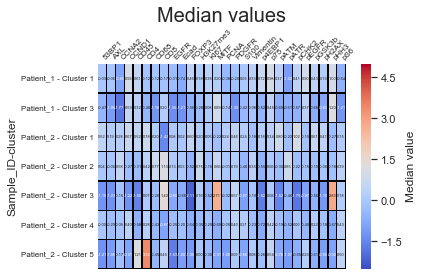

In [417]:
vmin = -2.5
vmax = 5

sb.set()

x_axis_labels = medians.columns.values.tolist()
y_axis_labels = [medians.iloc[i,:].name[0] + " - Cluster " + str(medians.iloc[i,:].name[1]) for i in range(data.shape[0])]

ax = sb.heatmap(data.loc[:,~data.columns.isin(not_intensities)], vmin=vmin, vmax=vmax, 
                 annot=data.loc[:,~data.columns.isin(not_intensities)], 
                annot_kws={"size": 4},fmt='.2f',
                linewidths = 0.33, linecolor = 'black',
                 xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                 cbar_kws = {'label':'Median value'},
                 cmap = 'coolwarm'
                )
plt.yticks(rotation=0, size = 8)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)
plt.xticks(rotation=45, size = 8)
plt.setp(ax.xaxis.get_majorticklabels(), ha='left')


ax.set_title(label = "Median values", fontsize = 20)
plt.tight_layout()

filename = "median_values.png"
filename = os.path.join(output_images_dir, filename)
plt.savefig(filename,dpi=300)

### Drop any other rows or columns we want to before saving data

In [ ]:
# Let's take a look
df.columns.values

For the sake of example, I will operate on a copy of df, called df_copy

In [ ]:
# You MUST do df.copy()
# 'df_copy = df' would essentially 
# give you two different names for the
# SAME dataframe, so operating on one
# would also operate on the other
df_copy = df.copy()

#### Operate on entire rows or columns

In [ ]:
# Drop columns
my_cols = []
df_copy = df_copy.drop(columns = my_cols)

In [ ]:
# Keep only specific columns (explained below)
my_cols = []
my_cols = df.columns.values
df_copy = df_copy.loc[:,my_cols]

#### Operate on rows and columns using filtering criteria

In [ ]:
# Keep only certain rows based off of criteria

# use df.loc[] to filter
# df.loc[rows,columns]
# df.loc[:,certain_cols] --> keep all rows ':', only certain cols
# df.loc[certain_rows,:] --> keep only certain row, all cols ':'

# Say we only want certain values for Sample_ID
print(df_copy.Sample_ID.unique())
keep = ['TMA1.1','TMA1.2','TMA1.3','TMA2.1','TMA2.2','TMA2.3']
df_copy = df_copy.loc[df_copy['Sample_ID'].isin(keep),:]
print(df_copy.Sample_ID.unique())

In [ ]:
# Filter on multiple criteria
# '&' or 'and'
# '|' or 'or'
# you MUST have parentheses around each logic expression!
df_copy = df_copy.loc[
    (df_copy['Sample_ID'].isin(['TMA1.1','TMA1.2','TMA1.3'])) \
    ## backslash above used to break line for readability, but tell Python to act like it's all one line
        | (df_copy['Sample_ID'].isin(['TMA2.1','TMA2.2','TMA2.3'])),:]
print(df_copy.Sample_ID.unique())

In [ ]:
# Remove rows based off of certain criteria
# note the negating tilde '~'!

df_copy = df_copy.loc[
    (~df_copy['Sample_ID'].isin(['TMA1.1','TMA1.2','TMA1.3'])) \
    ## backslash above used to break line for readability, but tell Python to act like it's all one line
        & (~df_copy['Sample_ID'].isin(['TMA2.1','TMA2.2','TMA2.3'])),:]
print(df_copy.Sample_ID.unique())

### Save the data by Sample_ID

In [75]:
# Check for existence of output file first
for sample in ls_samples:
    filename = sample + "_" + step_suffix + ".csv"
    filename = os.path.join(output_data_dir,  filename)
    if os.path.exists(filename):
        print("File by name "+filename+" already exists.")

In [76]:
# Save output files
for sample in ls_samples:
    df_save = df.loc[df['Sample_ID'] == sample,:]
    filename = sample + "_" + step_suffix + ".csv"
    filename = os.path.join(output_data_dir, filename)
    df_save.to_csv(filename, index = True)
